# LAB 4
# The basic setup for data assimilation (DA) workflow. 

## Representative example

Here we use `sin` function to demonstrate probabilistic programming (PP) approach. The PP allows flexibility and fitting of Bayesian statistical models. The [PyMC3](https://docs.pymc.io/en/v3/) is an open-source PP framework features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms. For more information see this [paper](https://peerj.com/articles/cs-55/). The original code can be found [here](https://github.com/zomorodiyan/pymc_note).

Author: Elchin Jafarov & Mehrdad Zomorodiyan 

Date: 02/28/2022

In [6]:
!pip install arviz
!pip install pymc3
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import arviz as az
az.style.use("arviz-darkgrid")
from IPython.display import display
import pymc3 as pm
#import theano.tensor as tt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

ContextualVersionConflict: (numpy 1.22.3 (/home/develop/.pyenv/versions/3.8.6/lib/python3.8/site-packages), Requirement.parse('numpy<1.22.2,>=1.15.0'), {'pymc3'})

Our model is equal to `sin(c*t+phi)`, which includes two unknowns `c` and `phi`. We try to calibrate our model parameters using PyMC3 Package. We choose  `sin` function, because it represent most of the output that we are going to deal with in DVM-DOS-TEM model, such as soil temprature, GPP, water content and others. Most of the DVM-DOS-TEM outputs have a form of the period function. That is why `sin` or `cos` functions seems like a natural choice for us. Below I outline the schematics for the eco/vegtype calibration that should be the final product using the DVM-DOS-TEM model. ![Ecotype/Vegetation type schematics](DA_schematics.png)

In [7]:
def model(t,c,phi):
    x = np.sin(c*t+phi)
    return x

Let's generate the random measurements using the above model

In [8]:
# generate random measurements with a white noise
sig = 0.2
t = np.linspace(0,1,20)
np.random.seed(seed=1)
f_e = np.sin(2*t+np.pi/2) + np.random.normal(0,sig,t.shape)

Visualize model and measurements 

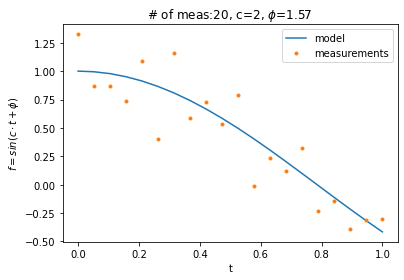

In [9]:
plt.plot(t,model(t,2,np.pi/2))
plt.plot(t,f_e,'.')
plt.gca().update(dict(title=('# of meas:'+str(20)+", c="+str(2)+", $\phi$="+str(1.57)),
                      xlabel='t', ylabel='$f=sin(c\cdot t+\phi)$'))
plt.legend(['model','measurements']);

In [10]:
# define model
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    c = pm.Uniform("c", lower=1, upper=10)
    phi = pm.Uniform("phi", lower=0, upper=2*np.pi)

    # Expected & Observed values
    #f = np.sin(c*t+phi)
    f = model(t,c,phi) # e.g. gpp for the specified time interval
    observed = f_e

    # Likelihood (sampling distribution) of observations
    sigma = pm.HalfNormal("sigma", sd=0.1)
    func = pm.Normal("func", mu=f,sd=sigma,observed=observed)

NameError: name 'pm' is not defined

In [6]:
type(sigma)

pymc3.model.TransformedRV

In [7]:
c

c ~ Uniform

In [8]:
phi

phi ~ Uniform

In [9]:
sigma

sigma ~ HalfNormal

In [10]:
func

func ~ Normal

In [7]:
# trace/sample model
with basic_model:
    trace = pm.sample(100, chains=1)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, phi, c]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


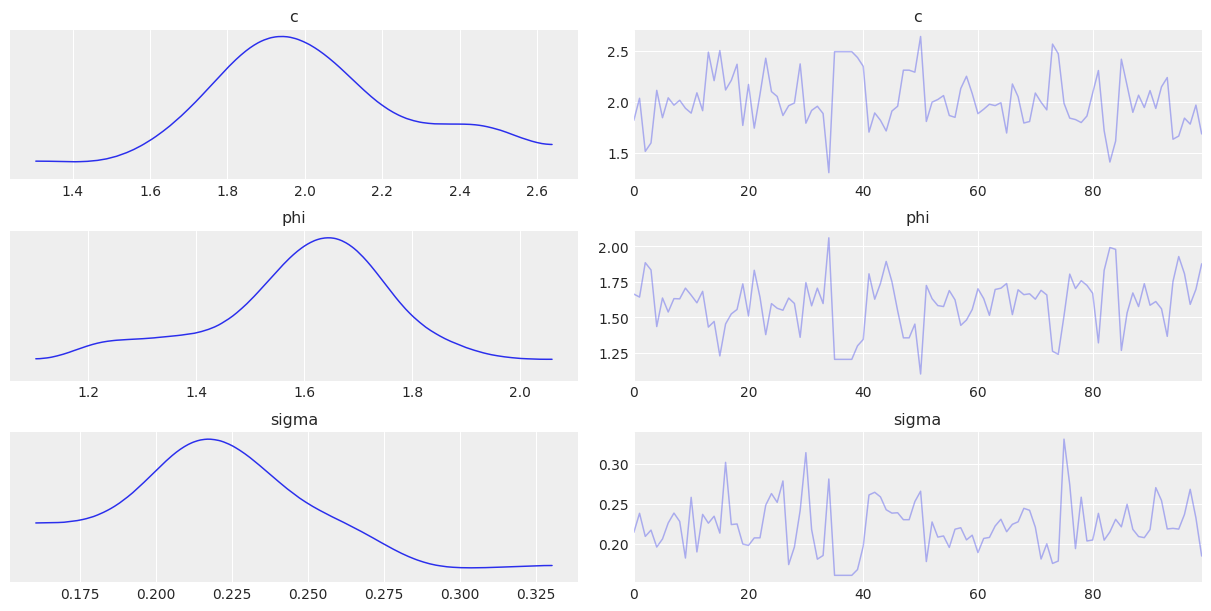

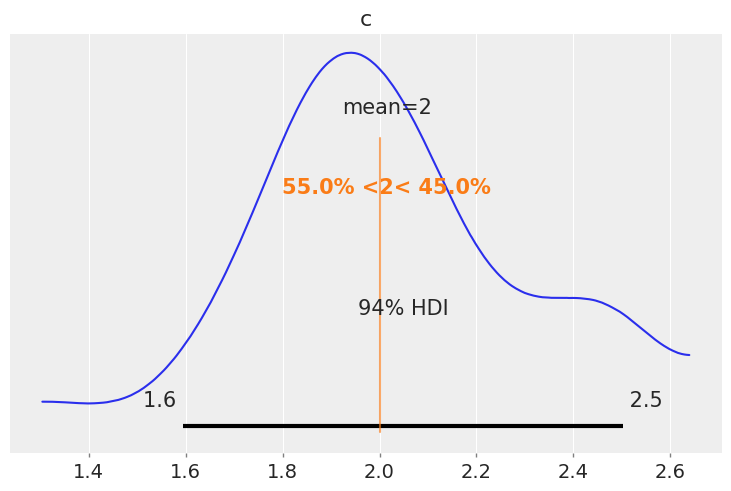

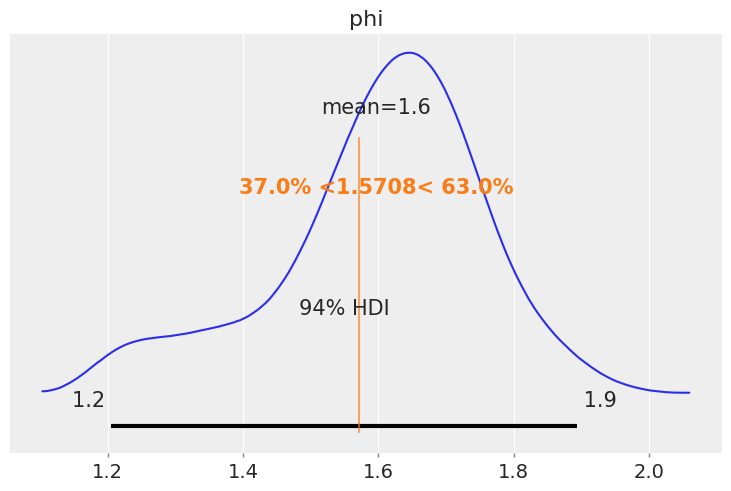

In [8]:
# plot outputs
with basic_model:
    pm.plot_trace(trace) # pm.plot_trace(trace,['nu','sigma'])
    az.plot_posterior(trace,['c'],ref_val=2)
    az.plot_posterior(trace,['phi'],ref_val=np.pi/2)

In [13]:
# show the stats
with basic_model:
    display(az.summary(trace, round_to=2))

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,1.98,0.26,1.53,2.49,0.02,0.01,257.41,338.67,NaN
phi,1.63,0.18,1.26,1.95,0.01,0.01,314.34,357.12,NaN
sigma,0.22,0.03,0.16,0.27,0.00,0.00,364.55,230.70,NaN


In [9]:
# show the stats
with basic_model:
    display(az.summary(trace, round_to=2))

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,2.02,0.27,1.60,2.50,0.03,0.02,66.49,58.94,NaN
phi,1.60,0.19,1.21,1.89,0.02,0.02,63.30,31.54,NaN
sigma,0.22,0.03,0.16,0.27,0.00,0.00,69.87,21.02,NaN


### Exercises: 
1. try sample sizes: 10, 100, 1000
2. reduce the noise to 0.1 and then inrease to 0.3. Do these changes afect the (c,phi, and sigma) 
2. add a linear term to the sin fuction (e.g. a*t)
3. modify the code to account for new term a  